# Импорт библиотек и загрузка данных

In [1]:
# Импортируем основные библиотеки
import numpy as np # linear algebra
import pandas as pd # data processing

import warnings
pd.options.mode.chained_assignment = None # SettingWithCopyWarning ignore
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning ignore

# Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем инструмент для разделения датасета
from sklearn.model_selection import train_test_split

# Загружаем дополнительные инструменты
from collections import Counter

# Загружаем инструменты для обработки отзывов
# !pip install nltk[twitter]
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Фиксируем RANDOM_SEED и версию пакетов, чтобы эксперименты были воспроизводимы.
RANDOM_SEED = 42
# !pip freeze > requirements.txt

# Загружаем инструменты для отбора признаков и создания модели
from sklearn.feature_selection import chi2 # тест хи-квадрат
from sklearn.feature_selection import f_classif # тест ANOVA
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
      --------------------------------------- 0.0/1.5 MB 1.3 MB/s eta 0:00:02
     --- ------------------------------------ 0.1/1.5 MB 1.7 MB/s eta 0:00:01
     ---------- ----------------------------- 0.4/1.5 MB 3.0 MB/s eta 0:00:01
     ------------------------ --------------- 0.9/1.5 MB 5.3 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 7.4 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 6.9 MB/s eta 0:00:00
  Obtaining dependency information for regex>=2021.8.3 from https://files.pythonhosted.org/packages/de/cd/d80c9e284ae6c1b2172dacf0651d25b78ee1f7efbc12d74ea7b87c766263/regex-2023.8.8-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ---------------------------------------- 42.0/42.0 kB ? eta 0:00:00
     ---------------------------------------- 0.0/151.7 kB ? eta -:--:--
     ---------------------

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Razer\AppData\Roaming\nltk_data...


In [2]:
# Подгрузим наши данные
df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания

In [3]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем трейн
df_test['sample'] = 0 # помечаем тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

В наших данных 9 числовых признаков, а остальные представлены типом object. Исследованием данных признаков мы и займёмся далее, но сначала заполним пропущенные значения.

# Очистка данных

Единственные признаки в которых есть пропуски это 'lat' и 'lng', они представляют собой коордитаны отеля. Самый простой вариант заполнения пропусков - заменить их медианным значением, но мы пойдём другим путём. В наших данных есть признаки названия и адреса отеля и с их помощью мы как раз попробуем решить нашу проблему с пропусками. 

Сначала посмотрим сколько уникальных отелей содержится в наших данных с пропущенными значениями.

In [5]:
print(f"Количество отелей с отсутствующими координатами: {data[data['lat'].isnull()]['hotel_name'].nunique()}.")

Количество отелей с отсутствующими координатами: 17.


Мы выяснили, что таких отелей совсем мало и у нас есть их адреса.

In [6]:
# Создадим список адресов таких отелей
hotels_wo_coord_adr = list(data[data['lat'].isnull()]['hotel_address'].unique())
hotels_wo_coord_adr

['W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
 '23 Rue Damr mont 18th arr 75018 Paris France',
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
 'Bail n 4 6 Eixample 08010 Barcelona Spain',
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
 '4 rue de la P pini re 8th arr 75008 Paris France',
 '20 Rue De La Ga t 14th arr 75014 Paris France',
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
 'Pau Clar s 122 Eixample 08009 Barcelona Spain',
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
 'Sep lveda 180 Eixample 08011 Barcelona Spain']

Проанализировав адреса мне удалось выяснить, что они по каким-то причинам заполнены некорректно. В каждом из них встречаются пропущенные символы (думаю, что это из-за кодирования, так как символы необычные) и можно предположить, что именно поэтому у них пропуски в координатах.

Придётся найти координаты вручную, имея приблизительный адрес и название отеля это выполнить возможно.

In [7]:
for n in range(data.shape[0]):
    if data['hotel_address'][n] == 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria':
        data['lat'][n] = 48.226203
        data['lng'][n] = 16.356822
    if data['hotel_address'][n] == 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria':
        data['lat'][n] = 48.222980
        data['lng'][n] = 16.357630
    if data['hotel_address'][n] == '23 Rue Damr mont 18th arr 75018 Paris France':
        data['lat'][n] = 48.886363
        data['lng'][n] = 2.349278
    if data['hotel_address'][n] == 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria':
        data['lat'][n] = 48.210918
        data['lng'][n] = 16.347119
    if data['hotel_address'][n] == 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria':
        data['lat'][n] = 48.213637
        data['lng'][n] = 16.380121
    if data['hotel_address'][n] == 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria':
        data['lat'][n] = 48.210834
        data['lng'][n] = 16.347110
    if data['hotel_address'][n] == 'Bail n 4 6 Eixample 08010 Barcelona Spain':
        data['lat'][n] = 41.390955
        data['lng'][n] = 2.155579
    if data['hotel_address'][n] == 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria':
        data['lat'][n] = 48.192880
        data['lng'][n] = 16.401198
    if data['hotel_address'][n] == '4 rue de la P pini re 8th arr 75008 Paris France':
        data['lat'][n] = 48.868109
        data['lng'][n] = 2.360294
    if data['hotel_address'][n] == '20 Rue De La Ga t 14th arr 75014 Paris France':
        data['lat'][n] = 48.827845
        data['lng'][n] = 2.321028
    if data['hotel_address'][n] == 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria':
        data['lat'][n] = 48.226431
        data['lng'][n] = 16.356993
    if data['hotel_address'][n] == 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria':
        data['lat'][n] = 48.219698
        data['lng'][n] = 16.285581
    if data['hotel_address'][n] == 'Pau Clar s 122 Eixample 08009 Barcelona Spain':
        data['lat'][n] = 41.392871
        data['lng'][n] = 2.167187
    if data['hotel_address'][n] == 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria':
        data['lat'][n] = 48.246253
        data['lng'][n] = 16.341845
    if data['hotel_address'][n] == 'Paragonstra e 1 11 Simmering 1110 Vienna Austria':
        data['lat'][n] = 48.166374
        data['lng'][n] = 16.445599
    if data['hotel_address'][n] == 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria':
        data['lat'][n] = 48.779481
        data['lng'][n] = 15.657069
    if data['hotel_address'][n] == 'Sep lveda 180 Eixample 08011 Barcelona Spain':
        data['lat'][n] = 41.401568
        data['lng'][n] = 2.135046

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Пропуски в данных заполнены.

# Проектироване признаков

In [9]:
# Для информации выведем количество уникальных значений в каждом признаке
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1489
lng                                             1489
sample                                             2
reviewer_score                                    38
dtype: int64

## Hotel Address

Рассмотрим каждый признак типа object по отдельности. Начнём с адреса отеля.

In [10]:
data['hotel_address'][0]

'Via Senigallia 6 20161 Milan Italy'

Из данного признака можем извлечь название страны и города, но в создании обоих признаков нет необходимости, так как каждой стране в наших данных соответствует один город.

Создадим признак страны отеля.

In [11]:
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()).apply(lambda x: x[-1]).apply(lambda x: 'UnitedKingdom' if x == 'Kingdom' else x)
data['hotel_country'].value_counts()

UnitedKingdom    262301
Spain             60149
France            59928
Netherlands       57214
Austria           38939
Italy             37207
Name: hotel_country, dtype: int64

## Review Date

Рассмотрим признак даты написания отзыва.

In [12]:
data['review_date'][0]

'7/21/2017'

Данный признак представляет собой дату, но в таком виде он нам не полезен.

Из него можно получить новые признаки, такие как год и месяц написания отзыва.

In [13]:
# Преобразуем наш признак в datetime
data['review_date'] = pd.to_datetime(data['review_date'])

In [14]:
# Создадим новые признаки
data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month

## Hotel Name

В данном признаке 1492 уникальных значения, то есть в нашем датасете содержатся отзывы по 1492 отелям.

На данный момент не вижу в нём особо полезной для модели информации.

## Reviewer Nationality

Тоже встречается множество различных значений, но не так много. Сохраним 25 самых популярных, а остальные 200 объединим в 'Other'.

In [15]:
# Удалим лишние пробелы
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.replace(' ', ''))

# Создадим список 25 самых популярных национальностей
top25_reviewer_nationality = data['reviewer_nationality'].value_counts().nlargest(25).index.to_list()

# Создадим признак
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top25_reviewer_nationality else 'Other')

In [16]:
data['reviewer_nationality'].value_counts()

UnitedKingdom            245246
Other                     75798
UnitedStatesofAmerica     35437
Australia                 21686
Ireland                   14827
UnitedArabEmirates        10235
SaudiArabia                8951
Netherlands                8772
Switzerland                8678
Germany                    7941
Canada                     7894
France                     7296
Israel                     6610
Italy                      6114
Belgium                    6031
Turkey                     5444
Kuwait                     4920
Spain                      4737
Romania                    4552
Russia                     3900
SouthAfrica                3821
India                      3437
Greece                     3406
China                      3400
Sweden                     3368
NewZealand                 3237
Name: reviewer_nationality, dtype: int64

## Negative Review & Positive Review

Предполагаю, что именно эти признаки содержат в себе самую важную для модели информацию, но представленна она в максимально для неё непонятном виде.

Изначально я вручную провёл их анализ, выделил основные фразы, которые посчитал как наиболее характерные для негативного и позитивного отзывов, но желаемого результата добиться не совсем получилось, поэтому далее воспользуюсь инструментом VADER (Valence Aware Dictionary and sEntiment Reasoner).

Сразу отметим, что если пользователь не написал, что ему не понравилось / понравилось, то в данных признаках содержатся фразы 'No Negative' / 'No Positive' и таких записей достаточно много. При анализе других работ мне удалось выяснить, что наш инструмент не совсем правильно воспринимает данные фразы (и не только их, но эти я посчитал основными), поэтому проделаем следующие шаги:

In [17]:
# Для информации выведем самые популярные значения данных признаков
data['negative_review_temp'] = data['negative_review'].apply(lambda x: x.lower().replace(' ', ''))
print(data['negative_review_temp'].value_counts().nlargest(3).index)

data['positive_review_temp'] = data['positive_review'].apply(lambda x: x.lower().replace(' ', ''))
print(data['positive_review_temp'].value_counts().nlargest(3).index)

Index(['nonegative', 'nothing', 'na'], dtype='object')
Index(['nopositive', 'location', 'everything'], dtype='object')


Самые популярные значения для данных признаков как раз 'No Negative' и 'No Positive'.

In [18]:
# Создадим временные признаки, в которых заменим те самые фразы на понятные для инструмента
data['negative_review_temp'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['positive_review_temp'] = data['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))

In [19]:
# Вызываем инструменты для оценки положительных и отрицательных отзывов:
sia_pos = SentimentIntensityAnalyzer()
sia_neg = SentimentIntensityAnalyzer()

In [20]:
# Запускаем инструмент
data['negative_review_sentiments'] = data['negative_review_temp'].apply(
    lambda x: sia_neg.polarity_scores(x))
data['positive_review_sentiments'] = data['positive_review_temp'].apply(
    lambda x: sia_pos.polarity_scores(x))

# Формируем новые признаки:
data['n_review_sentiments_neg'] = data['negative_review_sentiments'].apply(
    lambda x: x['neg'])
data['n_review_sentiments_neu'] = data['negative_review_sentiments'].apply(
    lambda x: x['neu'])
data['n_review_sentiments_pos'] = data['negative_review_sentiments'].apply(
    lambda x: x['pos'])
data['n_review_sentiments_compound'] = data['negative_review_sentiments'].apply(
    lambda x: x['compound'])

data['p_review_sentiments_neg'] = data['positive_review_sentiments'].apply(
    lambda x: x['neg'])
data['p_review_sentiments_neu'] = data['positive_review_sentiments'].apply(
    lambda x: x['neu'])
data['p_review_sentiments_pos'] = data['positive_review_sentiments'].apply(
    lambda x: x['pos'])
data['p_review_sentiments_compound'] = data['positive_review_sentiments'].apply(
    lambda x: x['compound'])

В результате мы получили целых 8 новых признаков, которые представляют из себя нормализованные оценки тональности текста по следующим категориям: негативная оценка, нейтральная оценка, позитивная оценка и составная оценка для двух наших исходных признаков.

## Tags

In [21]:
data['tags'][0]

"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']"

Из 'tags' можно получить множество новых признаков, как полезных, так и не особо. Рассмотрим его подробнее.

Сначала проанализируем, какие именно тэги могут в нём содержаться и какие из них наиболее популярные.

In [22]:
# Удалим лишние символы из строк и разделим на список по тегам
tags = data['tags'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", '').replace(' ', '').lower().split(','))

# Создадим список со всеми тегами
tags_list = list()

for str in tags:
    for tag in str:
        tags_list.append(tag)

In [23]:
# Посмотрим какие тэги встречаются чаще всего
tags = Counter(tags_list)
display(tags.most_common(25))

[('leisuretrip', 417778),
 ('submittedfromamobiledevice', 307640),
 ('couple', 252294),
 ('stayed1night', 193645),
 ('stayed2nights', 133937),
 ('solotraveler', 108545),
 ('stayed3nights', 95821),
 ('businesstrip', 82939),
 ('group', 65392),
 ('familywithyoungchildren', 61015),
 ('stayed4nights', 47817),
 ('doubleroom', 35207),
 ('standarddoubleroom', 32248),
 ('superiordoubleroom', 31393),
 ('familywitholderchildren', 26349),
 ('deluxedoubleroom', 24823),
 ('doubleortwinroom', 22393),
 ('stayed5nights', 20845),
 ('standarddoubleortwinroom', 17483),
 ('classicdoubleroom', 16989),
 ('superiordoubleortwinroom', 13570),
 ('2rooms', 12393),
 ('stayed6nights', 9776),
 ('standardtwinroom', 9745),
 ('singleroom', 9670)]

Можно заметить, что большая часть уникальных тегов это различные наименования для типов комнаты. Не думаю, что такая информация принесёт нам много пользы, пока не будем её использовать в модели.

Создадим следующие признаки:
1. Тип поездки;
2. Тип посетителя;
3. Продолжительность пребывания.

Конечно можно создать и другие признаки, но я выделил именно эти как основные, пока пусть будет так.

Также стоит отметить, что не каждая запись обязательно содержит информацию по всем этим признакам и пользователь мог указать различное количество тегов.

Перейдём к созданию признаков:

In [24]:
# Преобразуем их в списки без лишних символов
data['tags'] = data['tags'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", '').replace(' ', '').lower().split(','))

In [25]:
# Создадим признак trip_type
trip_types = ['leisuretrip', 'businesstrip'] # перечисляем возможные значения признака

def get_trip_types(x):
    for e in x:
        if e in trip_types:
            return e    

data['trip_type'] = data['tags'].apply(lambda x: get_trip_types(x)).fillna('unknown')
# Пропуски сразу решил заполнить как 'unknown' (в случае отстутствия нужной информации).

In [26]:
# Создадим признак guest_type
guest_types = ['couple', 'familywitholderchildren', 'familywithyoungchildren', 'group', 'solotraveler', 'travelerswithfriends']

def get_guest_types(x):
    for e in x:
        if e in guest_types:
            return e    

data['guest_type'] = data['tags'].apply(lambda x: get_guest_types(x)).fillna('unknown')

In [27]:
# Создадим признак nights_count
def get_nights_count(x):
    for e in x:
        if 'stayed' in e:
            e = e.replace('stayed', '').replace('night', '').replace('nights', '').replace('s', '')
            return e    

data['nights_count'] = data['tags'].apply(lambda x: get_nights_count(x)).fillna(0).astype('uint8')

## Days Since Review

In [28]:
data['days_since_review'][0]

'13 days'

Из него можно оставить количество дней от даты отсчёта до даты написания отзыва, но у нас и так есть признаки даты, не будем его использовать.

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

Мы рассмотрели все исходные признаки типа object и теперь можем их удалить, но перед этим необходимо выполнить кодирование некоторых новых полученных признаков, так как некоторые из них тоже представлены типом object и непригодны для модели.

# Кодирование и преобразование признаков

Для наших признаков будем использовать быстрое кодирование (One-Hot Encoding).

In [30]:
# Выделим признаки, которые можно быстро закодировать с помощью get_dummies.
to_get_dummies = ['hotel_country', 'reviewer_nationality', 'trip_type', 'guest_type']
data = pd.get_dummies(data, columns=to_get_dummies)

In [31]:
# Удалим лишний признак, который появился из-за того, что не во всех записях указан тип поездки.
data.drop('trip_type_unknown', axis = 1, inplace=True)

**Нормализация на результат по метрике MAPE никак не повлияла, поэтому применять её не будем.**

In [32]:
# Выберем числовые признаки, которые нуждаются в преобразовании
# to_norm = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 
#           'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng']

# Выбранные признаки распределены не нормально, поэтому применяем MinMaxScaler.

In [33]:
# Импортируем инструмент
# from sklearn import preprocessing

# Инициализируем нормализатор MinMaxScaler
# mm_scaler = preprocessing.MinMaxScaler()

# Нормализуем выбранные признаки
# data_mm = mm_scaler.fit_transform(data[to_norm])

# Преобразуем промежуточный датасет в полноценный датафрейм
# data_mm = pd.DataFrame(data_mm, columns=to_norm)

# Удаляем старые признаки и добавляем нормализованные
# data = data.drop(to_norm, axis=1)
# data = pd.concat([data, data_mm], axis=1)

# Отбор признаков

In [34]:
# Проверим, какие признаки типа object остались в наших данных.
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
object_columns

['hotel_address',
 'hotel_name',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review',
 'negative_review_temp',
 'positive_review_temp',
 'negative_review_sentiments',
 'positive_review_sentiments']

In [35]:
# Из данных признаков мы уже извлекли нужную информацию, удаляем их.
data.drop(object_columns, axis = 1, inplace=True)
data.drop('review_date', axis = 1, inplace=True) # review_date тоже можем удалить

In [36]:
# Выводим оставшиеся признаки
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 61 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

Признаки могут дублировать информацию, а это может негативно повлиять на качество модели, поэтому применим анализ мультиколлинеарности, чтобы выбрать уникальные признаки.

In [37]:
# Создаем дубликат базы для обратимости экспериментов
data_copy = data.copy()

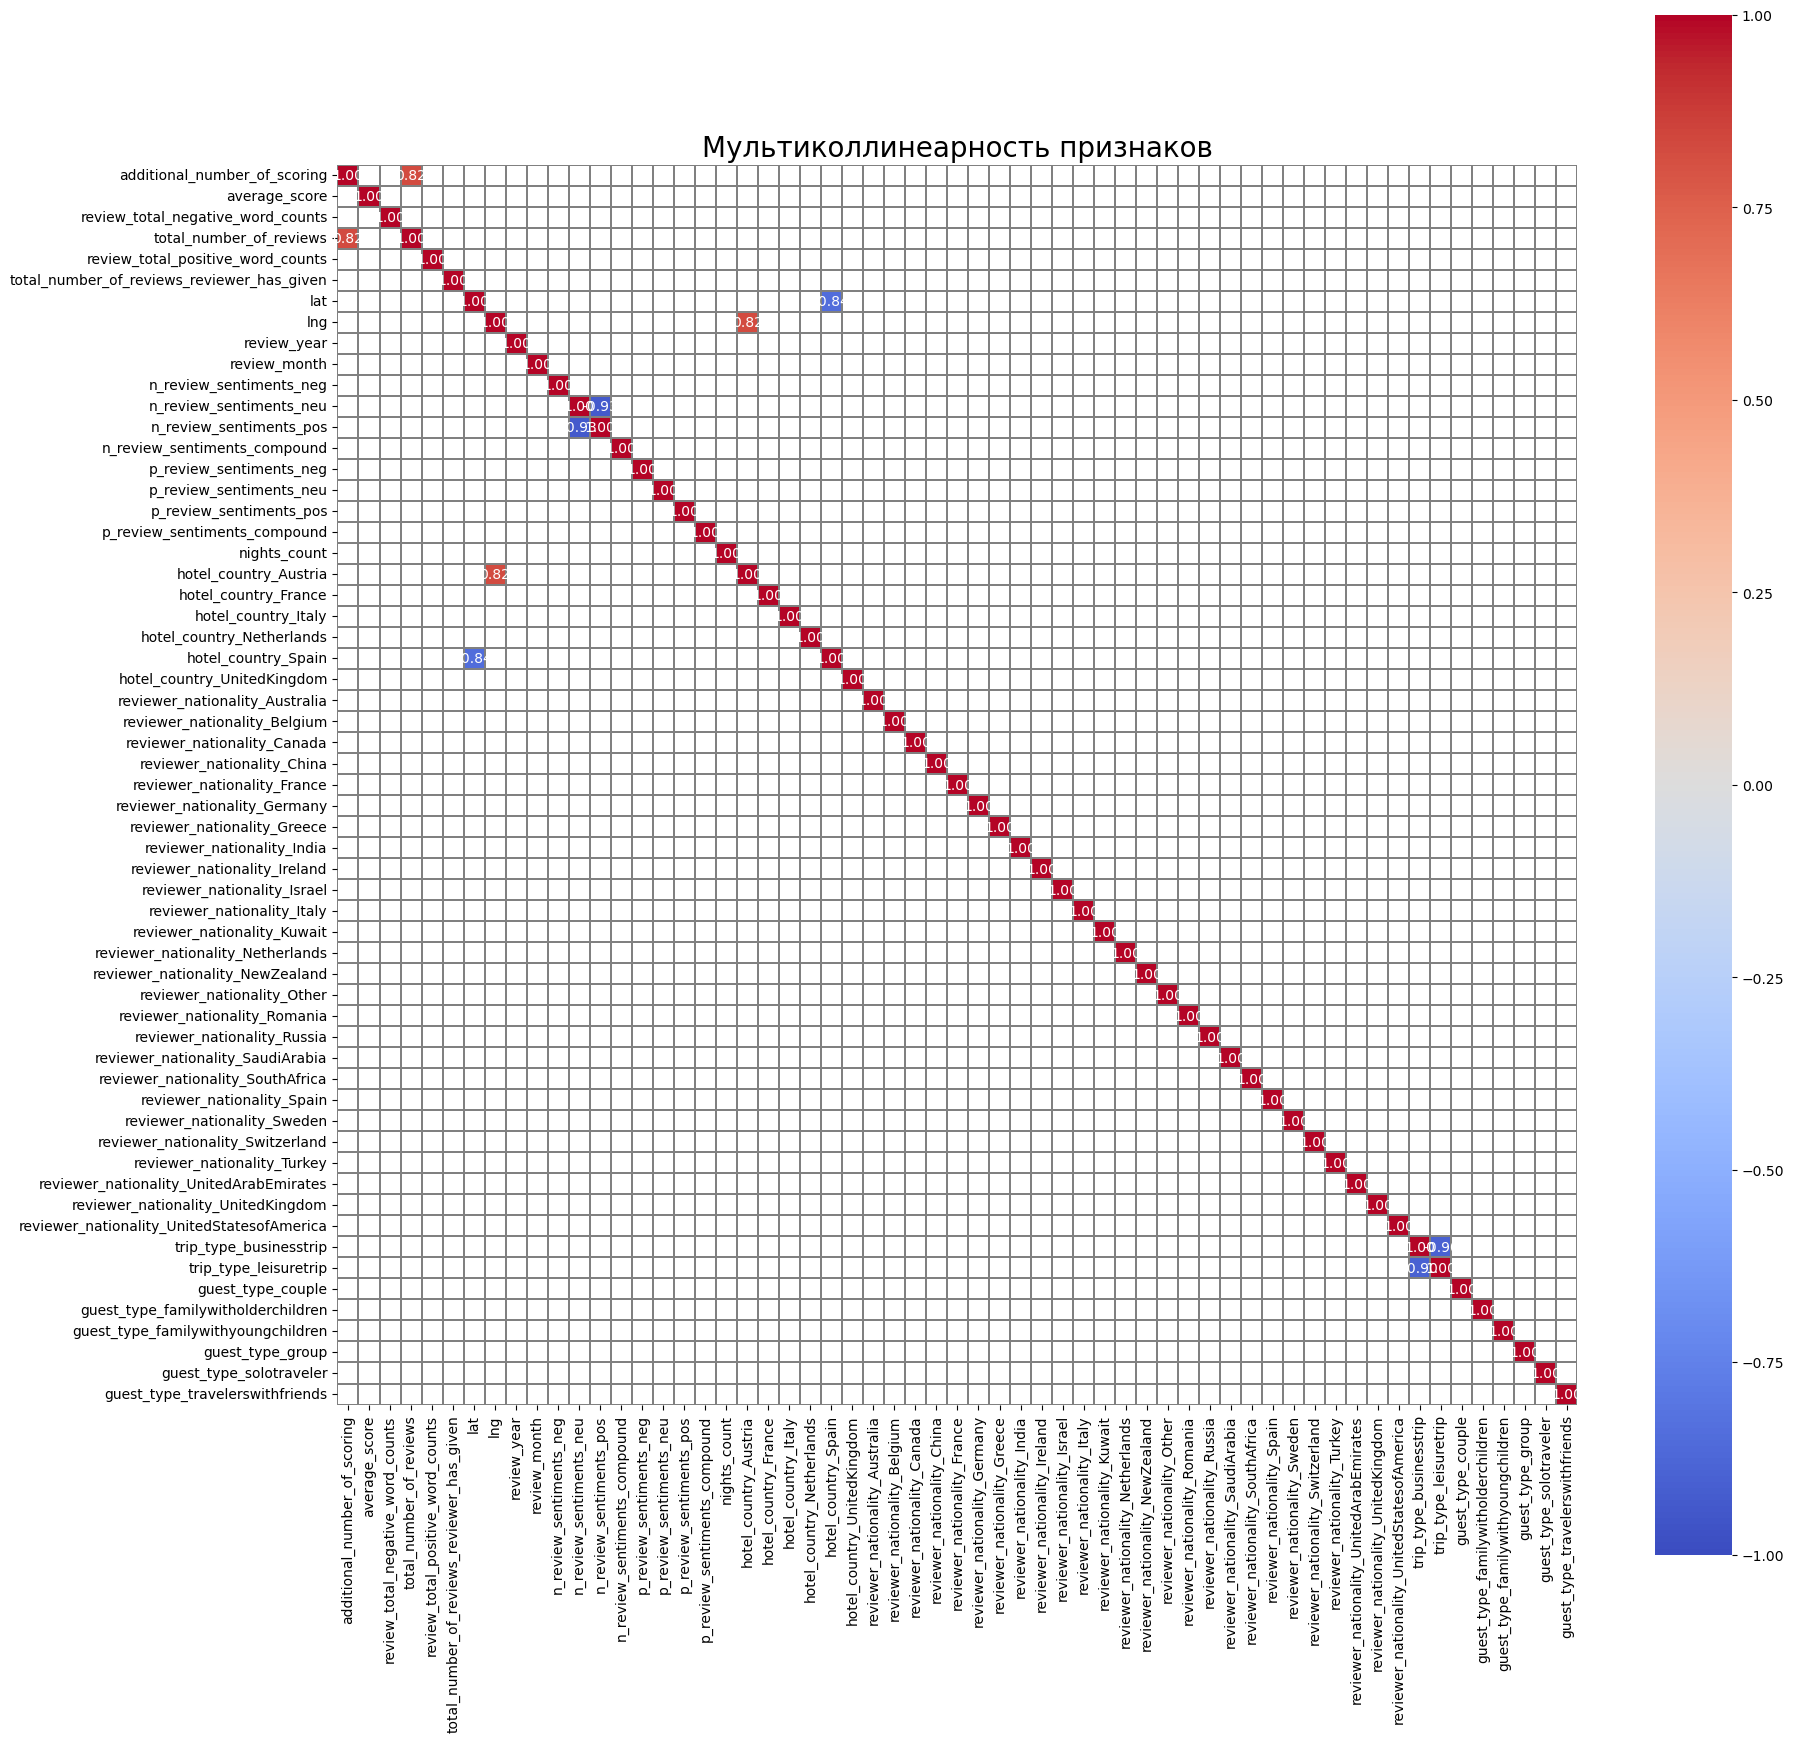

In [38]:
# Построим тепловую корреляционную матрицу и проанализируем данные на наличие мультиколлинеарности
# Данные для построения графика
corr = data_copy.drop(['reviewer_score', 'sample'], axis=1).corr()
plt.subplots(figsize=(20, 20))

# График - тепловая матрица с коэффициентами корреляции не менее 0.7
ax_heat_multicoll = sns.heatmap(
    corr[corr.abs() >= 0.7], 
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='gray', 
    cmap='coolwarm',
    annot = True,
    fmt='.2f',
    square=True
)

ax_heat_multicoll.set_title('Мультиколлинеарность признаков', fontsize=20);

На основе анализа мулитиколлинеарности можно сделать следующие выводы:
1. Признаки общего количества отзывов у отеля и количества отзывов без оценок имеют высокий коэффициент корреляции. В целом это логично, так как с ростом первого показателя, приблизительно также растёт и второй. Попробуем оставить один из них (оставим 'total_number_of_reviews');
2. Также высокую корреляцию имеют признаки координат отеля и страны его расположения. Можно попробовать пока оставить признаки координат, так как высокая корреляция только по двум странам из шести;
3. Признаки, которые мы получили в результате разбора позитивных и негативных отзывов, считаю, что лучше не трогать для 'полноты картины', посмотрим на анализ значимости для них;
4. Оба признака типа поездки, конечно же, оставлять не стоит. Оставим признак 'trip_type_leisuretrip', где '0' будет означать 'businesstrip'.

Также перед обучением (после разделения выборки на X и y) мы можем оценить значимость каждого признака для целевой переменной — рейтинг отеля. Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

In [39]:
# Выделим тестовую часть
y = data_copy.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int') # целевая переменная
X = data_copy.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

In [40]:
# Непрерывные числовые признаки
num_cols = ['review_total_negative_word_counts', 'review_total_positive_word_counts',
            'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given',
            'n_review_sentiments_neg','n_review_sentiments_neu', 'n_review_sentiments_pos',
            'n_review_sentiments_compound', 'p_review_sentiments_neg', 'p_review_sentiments_neu',
            'p_review_sentiments_pos', 'p_review_sentiments_compound',
            'lat', 'lng'] # не уверен куда лучше отнести координаты, к дискретным или к непрерывным,
                          # но так как хи-квадрат все равно выдаёт ошибку для отрицательных значений,
                          # пусть будут тут, думаю, не критично

# Категориальные признаки
cat_cols = ['average_score', 'review_year', 'review_month', 'nights_count',
            'hotel_country_Austria', 'hotel_country_France', 'hotel_country_Italy', 
            'hotel_country_Netherlands', 'hotel_country_Spain', 'hotel_country_UnitedKingdom',
            'reviewer_nationality_Australia', 'reviewer_nationality_Belgium', 'reviewer_nationality_Canada',
            'reviewer_nationality_China', 'reviewer_nationality_France', 'reviewer_nationality_Germany',
            'reviewer_nationality_Greece', 'reviewer_nationality_India', 'reviewer_nationality_Ireland',
            'reviewer_nationality_Israel', 'reviewer_nationality_Italy', 'reviewer_nationality_Kuwait',
            'reviewer_nationality_Netherlands', 'reviewer_nationality_NewZealand', 'reviewer_nationality_Other', 
            'reviewer_nationality_Romania', 'reviewer_nationality_Russia', 'reviewer_nationality_SaudiArabia',
            'reviewer_nationality_SouthAfrica', 'reviewer_nationality_Spain', 'reviewer_nationality_Sweden', 
            'reviewer_nationality_Switzerland', 'reviewer_nationality_Turkey', 'reviewer_nationality_UnitedArabEmirates', 
            'reviewer_nationality_UnitedKingdom', 'reviewer_nationality_UnitedStatesofAmerica',
            'trip_type_leisuretrip', 'guest_type_couple', 'guest_type_familywitholderchildren', 'guest_type_familywithyoungchildren', 
            'guest_type_group', 'guest_type_solotraveler', 'guest_type_travelerswithfriends']

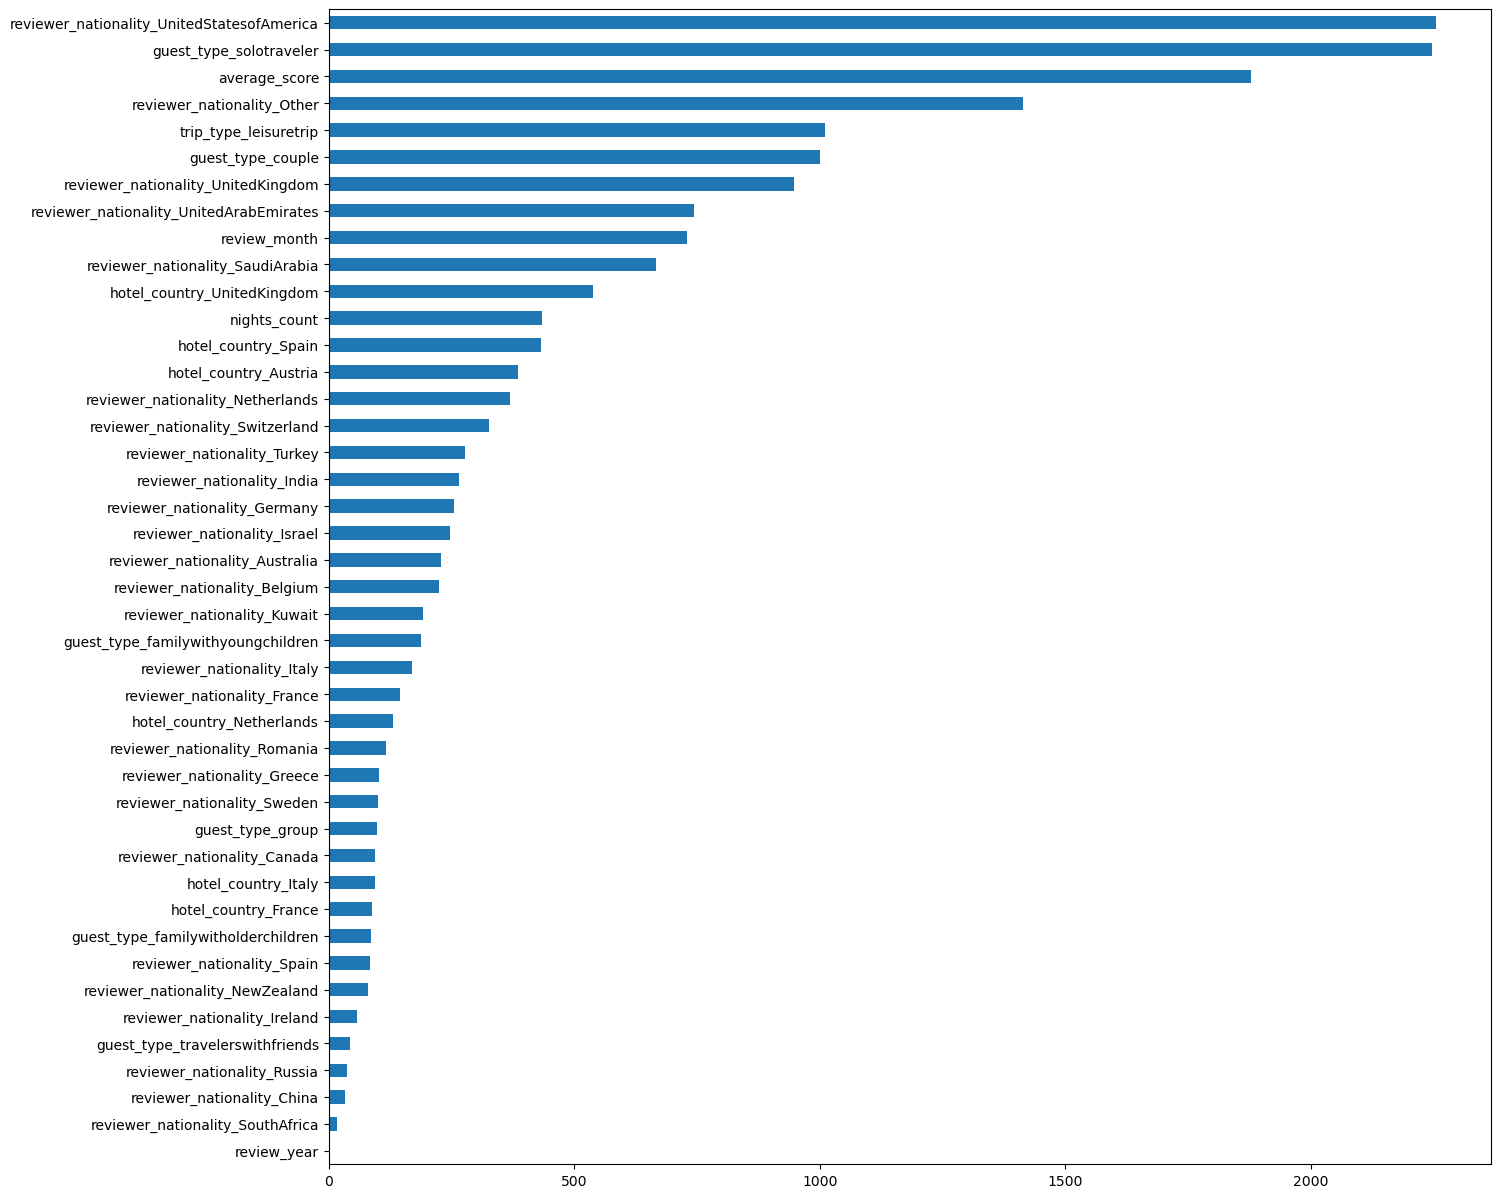

In [41]:
# Хи-квадрат для категориальных признаков 
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)

fig, ax = plt.subplots(figsize=(15, 15))
imp_cat.plot(kind = 'barh');

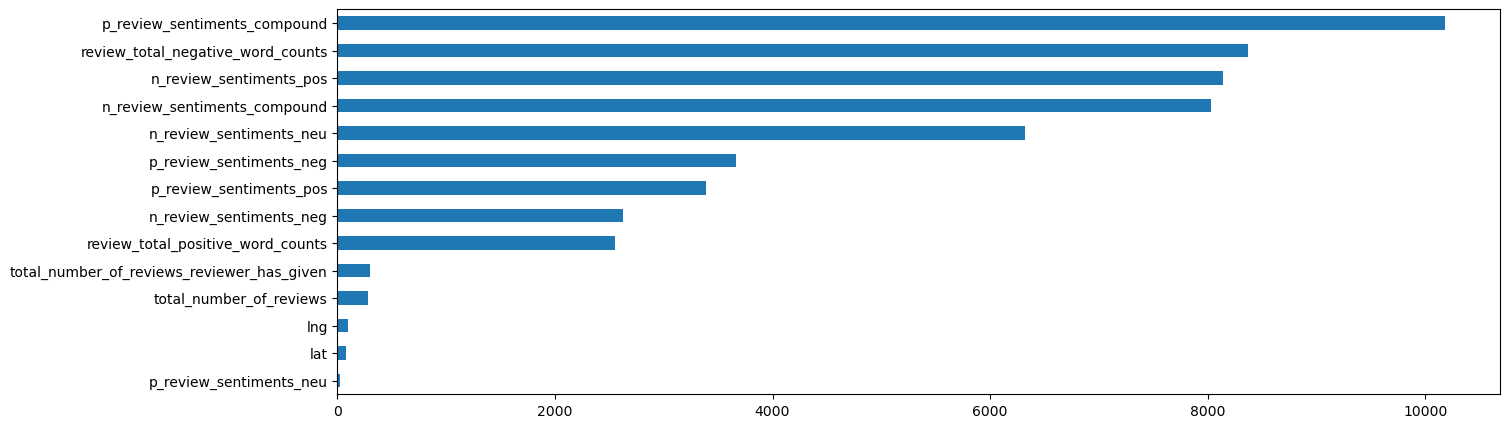

In [42]:
# ANOVA для непрерывных признаков 
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)

fig, ax = plt.subplots(figsize=(15, 5))
imp_num.plot(kind = 'barh');

Построим дополнительный график по тесту ANOVA для всех признаков без разделения, так как считаю, что нашу целевую переменную можно отнести к дискретным признакам и хотелось бы посмотреть на значимость всех признаков в целом для удобства оценки.

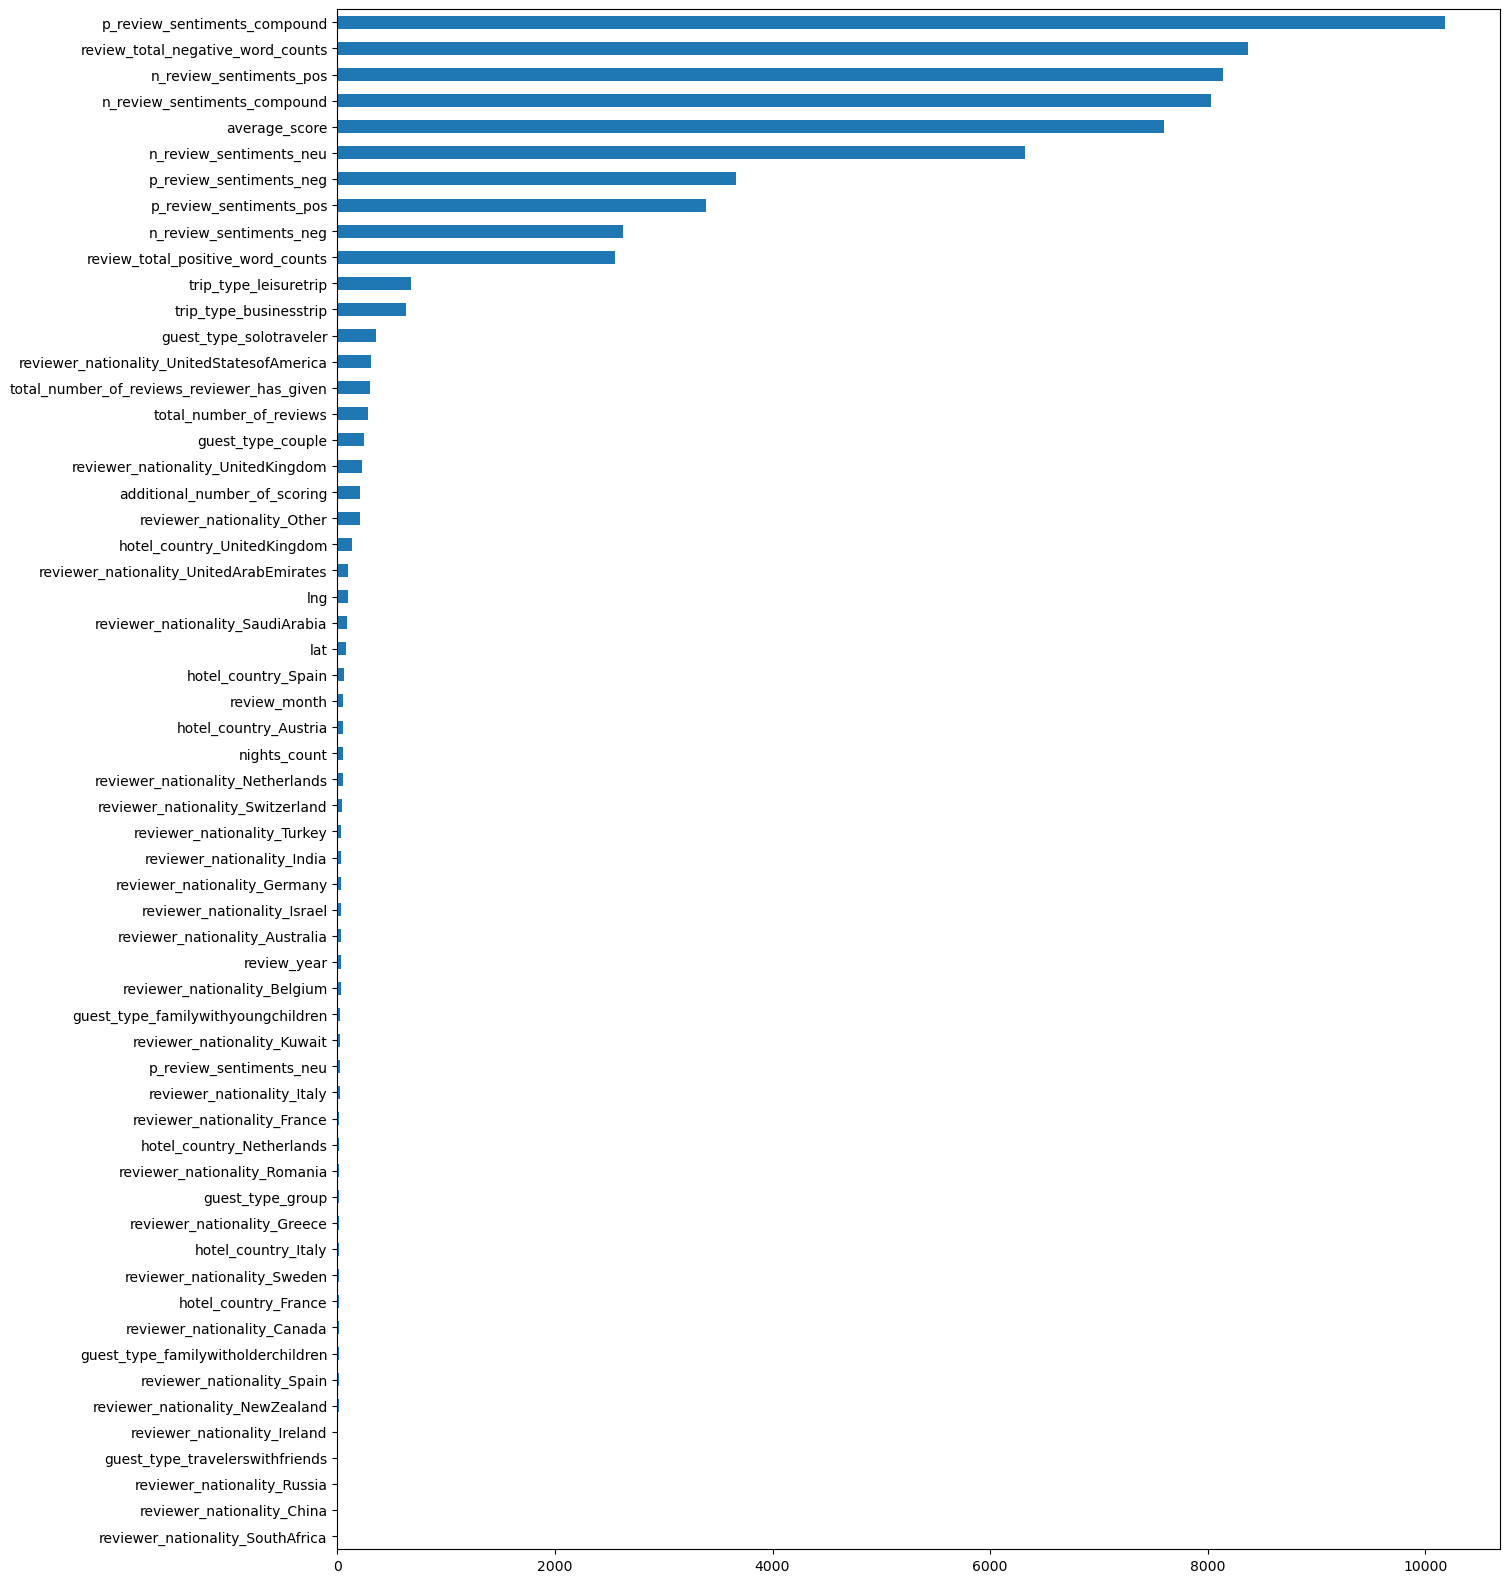

In [43]:
# ANOVA для всех признаков
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig, ax = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh');

Ситуация неоднозначная, на основании графиков мы видим, что многие признаки не несут практически никакой значимости для нашей модели, но и удалять их все не считаю целесообразным. Далее протестирую различные варианты наборов признаков для итоговой модели и сравню результаты. 

In [44]:
# Возможные признаки для удаления на основании анализа мультиколлениарности
to_drop_corr = ['trip_type_businesstrip', 'additional_number_of_scoring',
                'lat', 'lng',
                'n_review_sentiments_neu'
               ]


# Удаление признаков на основании анализа мультиколлениарности
data_copy.drop(to_drop_corr, axis = 1, inplace=True)

# Возможные признаки для удаления на основании оценки значимости
to_drop_sel = [# 'reviewer_nationality_SouthAfrica', 'reviewer_nationality_SouthAfrica', 'reviewer_nationality_China',
               # 'reviewer_nationality_Russia', 'guest_type_travelerswithfriends', 'reviewer_nationality_Ireland',
               
               # 'reviewer_nationality_NewZealand', 'reviewer_nationality_Spain', 'guest_type_familywitholderchildren',
               # 'reviewer_nationality_Canada', 'hotel_country_France', 'reviewer_nationality_Sweden',
               # 'hotel_country_Italy', 'reviewer_nationality_Greece', 'guest_type_group', 'reviewer_nationality_Romania',
               # 'hotel_country_Netherlands', 'reviewer_nationality_France',
               
               # 'reviewer_nationality_Italy', 'p_review_sentiments_neu', 'reviewer_nationality_Kuwait',
               # 'guest_type_familywithyoungchildren', 'reviewer_nationality_Belgium', 'review_year',
               # 'reviewer_nationality_Australia', 'reviewer_nationality_Israel', 'reviewer_nationality_Germany',
               # 'reviewer_nationality_India', 'reviewer_nationality_Turkey', 'reviewer_nationality_Switzerland',
               # 'reviewer_nationality_Netherlands', 'nights_count', 'hotel_country_Austria', 'review_month',
               # 'hotel_country_Spain', 'lat', 'reviewer_nationality_SaudiArabia', 'lng', 'reviewer_nationality_UnitedArabEmirates'
              ]

# Удаление признаков на основании оценки значимости
data_copy.drop(to_drop_sel, axis = 1, inplace=True)

# Создание и обучение модели

In [45]:
# Выделям тестовую часть
train_data = data_copy.query('sample == 1').drop(['sample'], axis=1)
test_data = data_copy.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

# Разбиваем тестовые данные, выделим 20% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test) по метрике MAPE
# Данная метрика показывает среднее отклонение предсказанных значений от фактических в процентах
def MAPE(y_test, y_pred): 
    y_true, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test))*100
print('MAPE:', (MAPE(y_test, y_pred)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


MAPE: 12.492504202367712


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


### Сравнение результатов:

1. MAPE: 12.51 без нормализации и отбора признаков;
2. MAPE: 12.51 с нормализацией, без отбора признаков;
3. MAPE: 12.57 удаление полного набора признаков (to_drop_corr и to_drop_sel)...

После множества попыток, итоговый результат на тестовой выборке получил 12.493 (после удаления признаков с высоким коэффициентом корреляции и без удаления малозначимых признаков), но разница между попытками все равно не велика. Основной вклад, конечно же, приносит EDA. 